# 2. Decision Tree Algorithms

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus  # visualization
import warnings
warnings.filterwarnings('ignore')

## (a) Construct a data science framework and show the data summary

決策樹是一種用於分類問題的演算法，採用樹形結構，使用層層推理來實現最終的分類。

決策數相較於迴歸分析的好處是

- 解釋性強
- 可以同時處理類別型資料與數值型資料
- 不需正規化，因為決策樹每次切割的重點是特徵的分佈而非其值

但同時決策樹也容易產生 overfitting，因為演算法繼續將節點分割爲子節點，直到每個節點變得均勻，這部分可以使用 pruning（修剪） 來解決

---

此題預計使用 sklearn 的 decision tree 演算法，針對鋼板缺陷進行分類，流程大致上如下：

1. 挑選切分點：
  - 對所有參數和分割點進行評估，每次都找到最佳選擇的切分點
  - 最佳指的是能使分割後的組內資料更為一致（pure）
  - 衡量 purity 的 criterion 可以是 entropy 或 gini index，其中 gini 適用於數據維度大，噪音很大的數據。
2. 生成決策樹：
  - 從根節點出發，選擇資訊增益最大的特徵作為節點，重複建立子節點，直到資訊增益很小或者沒有特徵可以選擇為止，便得到分類結果。
3. 修剪樹：避免 overfitting，可以透過：控制樹的深度、每個節點的最大/最小樣本數、要拆分的節點的最小不純度增益和最大葉節點等方法來實現。

首先來觀察一下資料集：

In [ ]:
df = pd.read_csv('/Users/kanko/Documents/NTU/MDS/MDS_Assignment3/MDS_Assignment3_Steelplates.csv', na_values='N/A')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              1941 non-null   int64  
 1   X_Maximum              1941 non-null   int64  
 2   Y_Minimum              1941 non-null   int64  
 3   Y_Maximum              1941 non-null   int64  
 4   Pixels_Areas           1941 non-null   int64  
 5   X_Perimeter            1941 non-null   int64  
 6   Y_Perimeter            1941 non-null   int64  
 7   Sum_of_Luminosity      1941 non-null   int64  
 8   Minimum_of_Luminosity  1941 non-null   int64  
 9   Maximum_of_Luminosity  1941 non-null   int64  
 10  Length_of_Conveyer     1941 non-null   int64  
 11  TypeOfSteel_A300       1941 non-null   int64  
 12  TypeOfSteel_A400       1941 non-null   int64  
 13  Steel_Plate_Thickness  1941 non-null   int64  
 14  Edges_Index            1941 non-null   float64
 15  Empt

In [ ]:
df.head()

X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0         42         50     270900     270944           267           17   
1        645        651    2538079    2538108           108           10   
2        829        835    1553913    1553931            71            8   
3        853        860     369370     369415           176           13   
4       1289       1306     498078     498335          2409           60   

   Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0           44              24220                     76   
1           30              11397                     84   
2           19               7972                     99   
3           45              18996                     99   
4          260             246930                     37   

   Maximum_of_Luminosity  ...  Orientation_Index  Luminosity_Index  \
0                    108  ...             0.8182           -0.2913   
1                    123  ...             0.7931           -0.1756   
2                    125  ...             0.6667           -0.1228   
3                    126  ...             0.8444           -0.1568   
4                    126  ...             0.9338           -0.1992   

   SigmoidOfAreas  Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  \
0          0.5822       1          0         0       0          0      0   
1          0.2984       1          0         0       0          0      0   
2          0.2150       1          0         0       0          0      0   
3          0.5212       1          0         0       0          0      0   
4          1.0000       1          0         0       0          0      0   

   Other_Faults  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 34 columns]

In [ ]:
df.describe()

X_Minimum    X_Maximum     Y_Minimum     Y_Maximum   Pixels_Areas  \
count  1941.000000  1941.000000  1.941000e+03  1.941000e+03    1941.000000   
mean    571.136012   617.964451  1.650685e+06  1.650739e+06    1893.878413   
std     520.690671   497.627410  1.774578e+06  1.774590e+06    5168.459560   
min       0.000000     4.000000  6.712000e+03  6.724000e+03       2.000000   
25%      51.000000   192.000000  4.712530e+05  4.712810e+05      84.000000   
50%     435.000000   467.000000  1.204128e+06  1.204136e+06     174.000000   
75%    1053.000000  1072.000000  2.183073e+06  2.183084e+06     822.000000   
max    1705.000000  1713.000000  1.298766e+07  1.298769e+07  152655.000000   

        X_Perimeter   Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
count   1941.000000   1941.000000       1.941000e+03            1941.000000   
mean     111.855229     82.965997       2.063121e+05              84.548686   
std      301.209187    426.482879       5.122936e+05              32.134276   
min        2.000000      1.000000       2.500000e+02               0.000000   
25%       15.000000     13.000000       9.522000e+03              63.000000   
50%       26.000000     25.000000       1.920200e+04              90.000000   
75%       84.000000     83.000000       8.301100e+04             106.000000   
max    10449.000000  18152.000000       1.159141e+07             203.000000   

       Maximum_of_Luminosity  ...  Orientation_Index  Luminosity_Index  \
count            1941.000000  ...        1941.000000       1941.000000   
mean              130.193715  ...           0.083288         -0.131305   
std                18.690992  ...           0.500868          0.148767   
min                37.000000  ...          -0.991000         -0.998900   
25%               124.000000  ...          -0.333300         -0.195000   
50%               127.000000  ...           0.095200         -0.133000   
75%               140.000000  ...           0.511600         -0.066600   
max               253.000000  ...           0.991700          0.642100   

       SigmoidOfAreas       Pastry    Z_Scratch     K_Scatch       Stains  \
count     1941.000000  1941.000000  1941.000000  1941.000000  1941.000000   
mean         0.585420     0.081401     0.097888     0.201443     0.037094   
std          0.339452     0.273521     0.297239     0.401181     0.189042   
min          0.119000     0.000000     0.000000     0.000000     0.000000   
25%          0.248200     0.000000     0.000000     0.000000     0.000000   
50%          0.506300     0.000000     0.000000     0.000000     0.000000   
75%          0.999800     0.000000     0.000000     0.000000     0.000000   
max          1.000000     1.000000     1.000000     1.000000     1.000000   

         Dirtiness        Bumps  Other_Faults  
count  1941.000000  1941.000000   1941.000000  
mean      0.028336     0.207110      0.346728  
std       0.165973     0.405339      0.476051  
min       0.000000     0.000000      0.000000  
25%       0.000000     0.000000      0.000000  
50%       0.000000     0.000000      0.000000  
75%       0.000000     0.000000      1.000000  
max       1.000000     1.000000      1.000000  

[8 rows x 34 columns]

## (b) What is the problem about the dataset? Any identical column? Any redundant column? Any missing value? How to handle these issues?

In [ ]:
df.isnull().any().any() # check missing value

False

In [ ]:
df.duplicated().sum()  # check duplicated
# df.loc[df.duplicated(), :]  # extract duplicated row

0

由於沒有遺漏值要補、重複值要丟棄，這部分僅作資料的切割。

In [ ]:
variables = df.drop(df.columns[27:], axis=1) # independent variables
defect = df.drop(df.columns[:27], axis=1) # defect type

In [ ]:
# 將 one-hot-encoding 的七種缺陷欄位合併為一欄
def defectEncoder(row):
    for i in defect.columns:
        if row[i] == 1:
            return i

defect = defect.apply(defectEncoder, axis=1)

In [ ]:
data = pd.concat([variables, defect], axis=1)
data.rename(columns = {0: 'Defect Type'}, inplace=True)
data

X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0            42         50     270900     270944           267           17   
1           645        651    2538079    2538108           108           10   
2           829        835    1553913    1553931            71            8   
3           853        860     369370     369415           176           13   
4          1289       1306     498078     498335          2409           60   
...         ...        ...        ...        ...           ...          ...   
1936        249        277     325780     325796           273           54   
1937        144        175     340581     340598           287           44   
1938        145        174     386779     386794           292           40   
1939        137        170     422497     422528           419           97   
1940       1261       1281      87951      87967           103           26   

      Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0              44              24220                     76   
1              30              11397                     84   
2              19               7972                     99   
3              45              18996                     99   
4             260             246930                     37   
...           ...                ...                    ...   
1936           22              35033                    119   
1937           24              34599                    112   
1938           22              37572                    120   
1939           47              52715                    117   
1940           22              11682                    101   

      Maximum_of_Luminosity  ...  Edges_X_Index  Edges_Y_Index  \
0                       108  ...         0.4706         1.0000   
1                       123  ...         0.6000         0.9667   
2                       125  ...         0.7500         0.9474   
3                       126  ...         0.5385         1.0000   
4                       126  ...         0.2833         0.9885   
...                     ...  ...            ...            ...   
1936                    141  ...         0.5185         0.7273   
1937                    133  ...         0.7046         0.7083   
1938                    140  ...         0.7250         0.6818   
1939                    140  ...         0.3402         0.6596   
1940                    133  ...         0.7692         0.7273   

      Outside_Global_Index  LogOfAreas  Log_X_Index  Log_Y_Index  \
0                      1.0      2.4265       0.9031       1.6435   
1                      1.0      2.0334       0.7782       1.4624   
2                      1.0      1.8513       0.7782       1.2553   
3                      1.0      2.2455       0.8451       1.6532   
4                      1.0      3.3818       1.2305       2.4099   
...                    ...         ...          ...          ...   
1936                   0.0      2.4362       1.4472       1.2041   
1937                   0.0      2.4579       1.4914       1.2305   
1938                   0.0      2.4654       1.4624       1.1761   
1939                   0.0      2.6222       1.5185       1.4914   
1940                   0.0      2.0128       1.3010       1.2041   

      Orientation_Index  Luminosity_Index  SigmoidOfAreas   Defect Type  
0                0.8182           -0.2913          0.5822        Pastry  
1                0.7931           -0.1756          0.2984        Pastry  
2                0.6667           -0.1228          0.2150        Pastry  
3                0.8444           -0.1568          0.5212        Pastry  
4                0.9338           -0.1992          1.0000        Pastry  
...                 ...               ...             ...           ...  
1936            -0.4286            0.0026          0.7254  Other_Faults  
1937            -0.4516           -0.0582          0.8173  Other_Faults  
1938            -0.4828 

將原始資料列 1941 筆隨機切割為 80% 訓練資料集 (1552筆) 與 20% 測試資料集 (389筆)。

In [ ]:
x = data.drop(data.columns[[27]], axis = 1)
y = data[['Defect Type']]

In [ ]:
# split training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
print("x train shape:", str(x_train.shape),
      "\ny train shape:", str(y_train.shape),
      "\nx test shape:", str(x_test.shape),
      "\ny test shape:", str(y_test.shape))

x train shape: (1552, 27) 
y train shape: (1552, 1) 
x test shape: (389, 27) 
y test shape: (389, 1)


## (c) Use the classification and regression tree (CART) to analyze the prepared dataset. 

Show the classification results by 10-fold cross validation with several metrics (eg. accuracy, area under ROC curve (AUC), and F1-score), and also list the hyperparameters you adjust.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

決策數模型常用參數：
- criterion: 指的是使用何種方法進行計算切分點，若是 ID3 則使用 entropy，若是 CART 則使用 gini。在 sklearn.tree.DecisionTreeClassifier 中，預設是 gini
- max_depth: 用來限制樹的最大深度。對於決策樹而言，樹的深度會決定資料是否 overfitting，越深的樹越容易 overfitting。為了找出此資料集適用的最大深度，我們先觀察用 max_depth=1~10 時，哪個值跑出來的 f1-score 表現較佳。
- 因為這邊的分類是 Multiclass 的，所以無法用單純的 f1-score，必須透過 macro, micro或是weighted f1-score
  - Macro-average F1-score: 直接將不同類別的評估指標（Precision/ Recall/ F1-score）加起來求平均，給所有類別相同的權重。該方法能夠平等看待每個類別，但是它的值容易受稀有類別影響，但反過來說也能保障小樣本不被忽略
  - Micro-average F1-score: 該方法把每個類別的TP, FP, FN先相加之後，在根據二分類的公式進行計算。相較於 macro，注重樣本真實分佈，只考慮全域性效果
  - Weighted-average F1-score: 該方法給不同類別不同權重（權重根據該類別的真實分佈比例確定），每個類別乘權重後再進行相加。該方法考慮了類別不平衡情況，它的值更容易受到常見類別的影響

在此我們先使用最單純的 macro-average

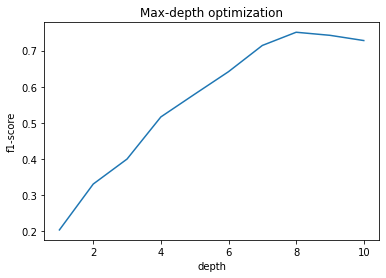

[0.20276268488747803, 0.3299681315226628, 0.399319658785983, 0.5160965094861237, 0.5791862532763877, 0.641548478228239, 0.7142773170374798, 0.7508962129260539, 0.7423728189292254, 0.7278720362139708] 
Max_depth is: 7


In [ ]:
scores=[]

for i in range(1,11):
  cart = DecisionTreeClassifier(criterion = "gini", max_depth=i)
  score = cross_val_score(cart, x_train, y_train, cv=10, scoring='f1_macro')
  scores.append(score.mean())


plt.plot(range(1,11), scores)
plt.xlabel("depth")
plt.ylabel("f1-score")
plt.title("Max-depth optimization")
plt.show()

print(scores, 
      "\nMax_depth is:",np.argmax(scores))

調整的參數如下：
- max_depth: 限制樹的深度避免 overfitting
- #min_impurity_decrease=0 -> 只有當分割確保不純度的減少大於或等於零時，節點才被分割

In [ ]:
# 使用表現較佳的 Max-depth 進行訓練
cart = DecisionTreeClassifier(criterion = "gini",
                              max_depth = 7).fit(x_train, y_train)
# 預測結果
pred_cart = cart.predict(x_test)

利用 confusion matrix 、accuracy 、 recall 、 f1-score 來評估訓練好的分類器好壞

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [ ]:
print("CART Accuracy score:", cart.score(x_test, y_test))

In [ ]:
matrix = confusion_matrix(y_test, pred_cart)
sns.heatmap(matrix, square=True, annot=True, cbar=False)
plt.xlabel("predict value")
plt.ylabel("true value")
plt.title("CART confusion matrix")
plt.show()

In [ ]:
list_defectType = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

In [ ]:
print("report:\n",
      classification_report(y_test, pred_cart,
                            target_names = list_defectType))

In [ ]:
# ROC curve of CART
y_test_label = label_binarize(y_test, classes=list_defectType)
pred_cart_label = label_binarize(pred_cart, classes=list_defectType)

n_classes = 7
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # one vs rest 計算每個類別的TPR/FPR以及AUC
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], pred_cart_label[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_label.ravel(), pred_cart_label.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) 

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC to Defect Type')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn import tree

In [ ]:
# take a glance at structure of decision tree
plt.figure(figsize = (30,20), dpi=100)
tree.plot_tree(cart)
plt.show()

In [ ]:
plt.figure(figsize = (100,50), dpi=100)
feature_name = x_train.columns

tree.plot_tree(cart,
               feature_names = feature_name, 
               class_names = list_defectType,
               filled = True);

## (d)Suggest a method to address the data imbalance issue. Build a new balanced dataset.

當遇到資料集不平衡的問題，以下有幾種常見方法：

1. oversampling: 增加資料
  - 簡單的例如將少量樣本複製使用（複製照片轉個角度、轉成黑白...）
  - 產生合成樣本 (Synthetic Sample)
    - SMOTE / AdaSyn: 用「最近鄰點」(Nearest Neighbors) 為出發的方法產生新資料
    - GAN: 利用生成與對抗模型產生相似分配的資料
    - 利用貝氏網絡 (Bayesian Network) 產生具有相似變數結構的新資料

2. undersampling: 刪減資料
  - Tamek Link: 刪除與邊界上陽性個體很靠近的陰性個體，直到每一個陽性個體附近的最近鄰點 (Nearest Neighbor) 都是陽性的


這次我們使用 imblearn 的演算法進行 oversampling，首先來看一下原本的 defect type 分布:

Defect Type 
Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
dtype: int64

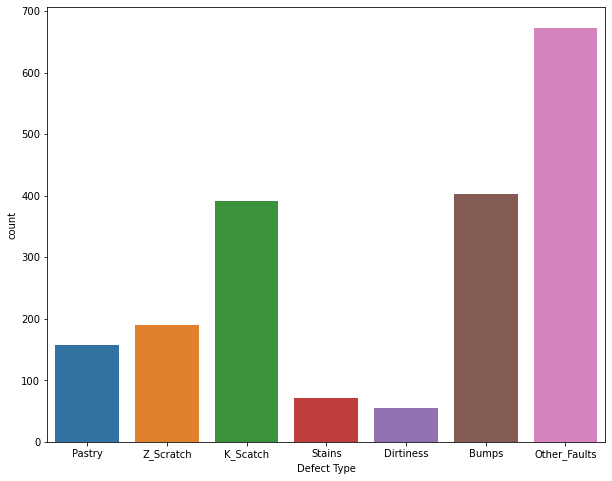

In [ ]:
# shows the Defect Type distribution
plt.figure(figsize=(10,8))
sns.countplot(data['Defect Type'])
data.value_counts(["Defect Type"])

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
x_smote, y_smote = SMOTE().fit_resample(x_train, y_train)

In [ ]:
x_smote.shape, y_smote.shape

((3710, 27), (3710, 1))

Defect Type
Bumps           530
Dirtiness       530
K_Scatch        530
Other_Faults    530
Pastry          530
Stains          530
Z_Scratch       530
dtype: int64

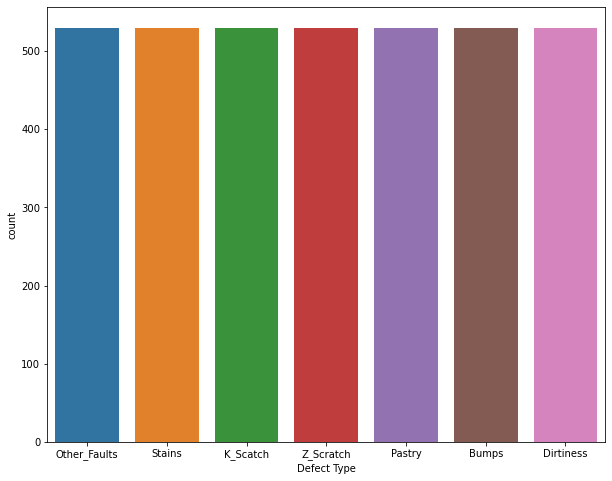

In [ ]:
# shows the Defect Type distribution with SMOTE
plt.figure(figsize=(10,8))
sns.countplot(y_smote['Defect Type'])
y_smote.value_counts(y_smote["Defect Type"])

## (e) Based on the balanced dataset, use the classification and regression tree (CART) to analyze the balanced dataset.

Show the classification results by 10-fold cross validation with several metrics (eg. accuracy, area under ROC curve (AUC), and F1-score), and also list the hyperparameters you adjust.

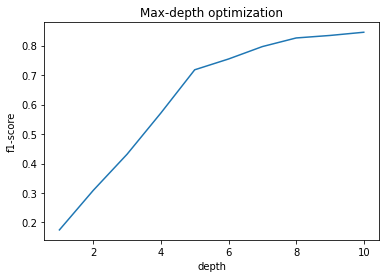

[0.17468788206967123, 0.3087179859152287, 0.43137710900805015, 0.5712970882651875, 0.7178872884913046, 0.7545024536430093, 0.7966066107491409, 0.8258756742287223, 0.8343770422260766, 0.8452860596772733] 
Max_depth is: 9


In [ ]:
scores_smote=[]

for i in range(1,11):
    smote = DecisionTreeClassifier(criterion = "gini", max_depth=i)
    score = cross_val_score(smote, x_smote, y_smote, cv=10, scoring='f1_macro')
    scores_smote.append(score.mean())


plt.plot(range(1,11), scores_smote)
plt.xlabel("depth")
plt.ylabel("f1-score")
plt.title("Max-depth optimization")
plt.show()

print(scores_smote, 
      "\nMax_depth is:",np.argmax(scores_smote))

In [ ]:
# 使用表現較佳的 Max-depth 進行訓練
smote = DecisionTreeClassifier(criterion = "gini",
                               max_depth = 9).fit(x_smote, y_smote)
# 預測結果
pred_smote = smote.predict(x_test)

In [ ]:
print("SMOTE Accuracy score:", smote.score(x_test, y_test))

SMOTE Accuracy score: 0.712082262210797


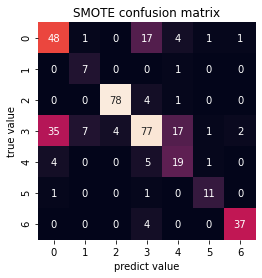

In [ ]:
# confusion matrix
matrix = confusion_matrix(y_test, pred_smote)
sns.heatmap(matrix, square=True, annot=True, cbar=False)
plt.xlabel("predict value")
plt.ylabel("true value")
plt.title("SMOTE confusion matrix")
plt.show()

In [ ]:
print("report:\n",
      classification_report(y_test, pred_smote,
                            target_names = list_defectType))

report:
               precision    recall  f1-score   support

      Pastry       0.55      0.67      0.60        72
   Z_Scratch       0.47      0.88      0.61         8
    K_Scatch       0.95      0.94      0.95        83
      Stains       0.71      0.54      0.61       143
   Dirtiness       0.45      0.66      0.54        29
       Bumps       0.79      0.85      0.81        13
Other_Faults       0.93      0.90      0.91        41

    accuracy                           0.71       389
   macro avg       0.69      0.77      0.72       389
weighted avg       0.73      0.71      0.71       389



In [ ]:
# plot CART with SMOTE
plt.figure(figsize = (150,50), dpi=150)
tree.plot_tree(smote,
               feature_names = feature_name, 
               class_names = list_defectType,
               filled = True);

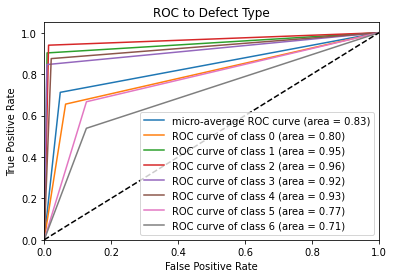

In [ ]:
# ROC curve of CART with SMOTE
pred_smote_label = label_binarize(pred_smote, classes = list_defectType)

n_classes = 7
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # one vs rest 計算每個類別的TPR/FPR以及AUC
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], pred_smote_label[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_label.ravel(), pred_smote_label.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) 

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC to Defect Type')
plt.legend(loc="lower right")
plt.show()

## (f) Give a comparison between (c) and (e).
Any suggestion or insight?

用 SMOTE 重新採樣後的 CART 雖然 model accuracy 相去不遠，但是有以下差別：
1. 之前表現特別差的類別如 Pastry, Dirtiness 分數皆有進步。
2. ROC 大致上向左上靠齊，且較為一致

代表了 SMOTE 確實能改善 imbalance issue


## (g) Random Forest on both prepared dataset and balanced dataset, respectively.



在決策樹中，除了pruning（限制 max depth 等 ，還有其他方式也能處理 decision tree 的 overfitting 問題，如 Bagging

- Bagging

概念是對原本的資料中取後放回，因為這些隨機資料組合訓練出來的分類器也會不同，我們再用所有分類器的結果來進行多數決投票。將一堆弱學習器結合，建構出一個更強的模型，可以說是一種 ensemble learning。

- Random Forest

*Random Forest = Bagging + Fully-grown CART decision tree*

RandomForest 部分：傳入Bagging完的資料並決定我們希望用多少棵樹來建構森林，每一次 iteration 會建立出一棵樹，我們將這些樹的預測結果儲存下來，最後相加得到一個整數，該整數如果大於 0 代表較多棵樹判斷為 +1，反過來說則是較多棵樹認為是 -1。透過將這樣的分類結果相加後，我們可以得到在每個資料上實際的 label，以及隨機森林多數決的結果。

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# training Random Forest model with original data
rf_imb = RandomForestClassifier(n_estimators = 100,  # amount of decision tree
                                random_state = 42).fit(x_train, y_train)

# prediction result
pred_rf_imb = rf_imb.predict(x_test)

In our visualization part, considering that the graph of Random Forest might be more complicated than single decision tree, so I prefered exporting png file rather than displaying inline. The same method will apply to GBDT later.

In [ ]:
# visualization
from sklearn.tree import export_graphviz

# pull out one tree from the forest
graph_rf_imb = rf_imb.estimators_[5]

# export image to a dot file
export_graphviz(graph_rf_imb, out_file = 'rf_imb.dot', feature_names = feature_name, rounded = True, precision = 1)

# use dot file to create graph
graph = pydotplus.graph_from_dot_file('rf_imb.dot')

# write graph to a png file
graph.write_png('rf_imb.png')

True

In [ ]:
print("Random Forest Accuracy score:", rf_imb.score(x_test, y_test))

Random Forest Accuracy score: 0.7763496143958869


In [ ]:
# confusion matrix
matrix = confusion_matrix(y_test, pred_rf_imb)
sns.heatmap(matrix, square = True, annot = True, cbar = False)
plt.xlabel("predict value")
plt.ylabel("true value")
plt.title("Random Forest confusion matrix")
plt.show()

In [ ]:
print("report:\n",
      classification_report(y_test, pred_rf_imb,
                            target_names = list_defectType))

report:
               precision    recall  f1-score   support

      Pastry       0.63      0.64      0.63        72
   Z_Scratch       0.60      0.75      0.67         8
    K_Scatch       0.96      0.93      0.94        83
      Stains       0.73      0.77      0.75       143
   Dirtiness       0.58      0.48      0.53        29
       Bumps       1.00      0.92      0.96        13
Other_Faults       0.93      0.90      0.91        41

    accuracy                           0.78       389
   macro avg       0.78      0.77      0.77       389
weighted avg       0.78      0.78      0.78       389



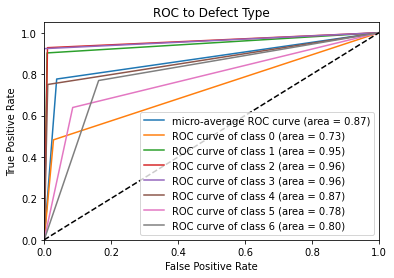

In [ ]:
# ROC curve of Random Forest
pred_rf_imb_label = label_binarize(pred_rf_imb, classes = list_defectType)

n_classes = 7
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # one vs rest 計算每個類別的TPR/FPR以及AUC
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], pred_rf_imb_label[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_label.ravel(), pred_rf_imb_label.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) 

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label = 'micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label = 'ROC curve of class {0} (area = {1:0.2f})'
                                     ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC to Defect Type')
plt.legend(loc="lower right")
plt.show()

Apply Random Forest on balanced data

In [ ]:
# create base model for tuning
rf_bal = RandomForestClassifier(n_estimators = 100,  # amount of decision tree
                                random_state = 42).fit(x_smote, y_smote)
# prediction result
pred_rf_bal = rf_bal.predict(x_test)

In [ ]:
# visualization
# pull out one tree from the forest
graph_rf_bal = rf_bal.estimators_[5]

# export image to a dot file
export_graphviz(graph_rf_bal, out_file = 'rf_bal.dot', feature_names = feature_name, rounded = True, precision = 1)

# use dot file to create graph
graph = pydotplus.graph_from_dot_file('rf_bal.dot')

# write graph to a png file
graph.write_png('rf_bal.png')

True

In [ ]:
print("Random Forest Accuracy score:", rf_bal.score(x_test, y_test))

Random Forest Accuracy score: 0.7660668380462725


In [ ]:
# confusion matrix
matrix = confusion_matrix(y_test, pred_rf_bal)
sns.heatmap(matrix, square=True, annot=True, cbar=False)
plt.xlabel("predict value")
plt.ylabel("true value")
plt.title("Random Forest(balance) confusion matrix")
plt.show()

In [ ]:
print("report:\n",
      classification_report(y_test, pred_rf_bal,
                            target_names = list_defectType))

report:
               precision    recall  f1-score   support

      Pastry       0.60      0.68      0.64        72
   Z_Scratch       0.60      0.75      0.67         8
    K_Scatch       0.96      0.94      0.95        83
      Stains       0.77      0.66      0.71       143
   Dirtiness       0.55      0.72      0.63        29
       Bumps       0.92      0.92      0.92        13
Other_Faults       0.90      0.90      0.90        41

    accuracy                           0.77       389
   macro avg       0.76      0.80      0.77       389
weighted avg       0.78      0.77      0.77       389



In [ ]:
# ROC curve of Random Forest with SMOTE
pred_rf_bal_label = label_binarize(pred_rf_bal, classes = list_defectType)

n_classes = 7
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # one vs rest 計算每個類別的TPR/FPR以及AUC
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], pred_rf_bal_label[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_label.ravel(), pred_rf_bal_label.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) 

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC to Defect Type')
plt.legend(loc="lower right")
plt.show()

可以看到截至目前為止，隨機森林整體表現優於單棵決策樹，其中，利用 balance dataset 的隨機森林，更是在每個類別皆達到 0.6 以上的 f1-score 

從一棵 CART 走到一片隨機森林的路上，其實正是降低 model complexity，避免 overfitting，藉此更接近 optimal VC dimension。建樹也建林，讓模型能夠免於見樹不見林的危險。

## (i) Gradient Boosting Decision Tree (GBDT) on both prepared dataset and balanced dataset, respectively.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# create base model for tuning
GBDT = GradientBoostingClassifier(random_state = 42)

# 建立參數組合
GBDT_param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [7, 8, 9, 10],
    'learning_rate': [.01, .1, .2, .3, .4, .5, .6]
}

# Random search cv
from sklearn.model_selection import RandomizedSearchCV


GBDT_random = RandomizedSearchCV(estimator = GBDT,
                                 param_distributions = GBDT_param_grid,
                                 scoring = "accuracy",
                                 verbose = 1,
                                 cv = 10,
                                 random_state = 42)

# 使用訓練資料訓練模型
GBDT_random.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=42),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4, 0.5, 0.6],
                                        'max_depth': [7, 8, 9, 10],
                                        'n_estimators': [100, 500, 1000]},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
print("\nBest model:",GBDT_random.best_estimator_,
      "\nWith parameter set:\n", GBDT_random.best_params_,
      "\nMean cross-validated score of the best_estimator:\n", GBDT_random.best_score_)


Best model: GradientBoostingClassifier(max_depth=7, random_state=42) 
With parameter set:
 {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1} 
Mean cross-validated score of the best_estimator:
 0.79767576509512


In [ ]:
# training GBDT model with original data
GBDT_imb = GradientBoostingClassifier(learning_rate = 0.1, 
                                      n_estimators = 100,
                                      max_depth = 7,
                                      random_state = 42).fit(x_train, y_train)

# prediction result
pred_GBDT_imb = GBDT_imb.predict(x_test)

In [ ]:
# visualization
# pull out one tree from the forest
graph_GBDT_imb = GBDT_imb.estimators_[5,0]

# export image to a dot file
export_graphviz(graph_GBDT_imb, out_file = 'GBDT_imb.dot', feature_names = feature_name, rounded = True, precision = 1)

# use dot file to create graph
graph = pydotplus.graph_from_dot_file('GBDT_imb.dot')

# write graph to a png file
graph.write_png('GBDT_imb.png')

True

In [ ]:
print("GBDT Accuracy score:", GBDT_random.score(x_test, y_test))

GBDT Accuracy score: 0.8020565552699229


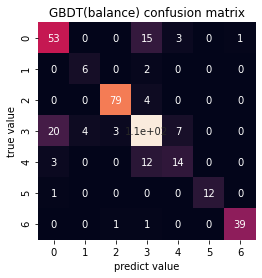

In [ ]:
# confusion matrix
matrix = confusion_matrix(y_test, pred_GBDT_imb)
sns.heatmap(matrix, square=True, annot=True, cbar=False)
plt.xlabel("predict value")
plt.ylabel("true value")
plt.title("GBDT(balance) confusion matrix")
plt.show()

In [ ]:
print("report:\n",
      classification_report(y_test, pred_GBDT_imb,
                            target_names = list_defectType))

report:
               precision    recall  f1-score   support

      Pastry       0.69      0.74      0.71        72
   Z_Scratch       0.60      0.75      0.67         8
    K_Scatch       0.95      0.95      0.95        83
      Stains       0.76      0.76      0.76       143
   Dirtiness       0.58      0.48      0.53        29
       Bumps       1.00      0.92      0.96        13
Other_Faults       0.97      0.95      0.96        41

    accuracy                           0.80       389
   macro avg       0.79      0.79      0.79       389
weighted avg       0.80      0.80      0.80       389



In [ ]:
# ROC curve of GBDT
pred_GBDT_imb_label = label_binarize(pred_GBDT_imb, classes = list_defectType)

n_classes = 7
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # one vs rest 計算每個類別的TPR/FPR以及AUC
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], pred_GBDT_imb_label[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_label.ravel(), pred_GBDT_imb_label.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) 

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC to Defect Type')
plt.legend(loc="lower right")
plt.show()

Apply GBDT to balance data

In [ ]:
# create base model for tuning
GBDT_bal = GradientBoostingClassifier(random_state = 42)

# Random search cv
GBDT_random_bal = RandomizedSearchCV(estimator = GBDT_bal,
                                     param_distributions = GBDT_param_grid,
                                     scoring = "accuracy",
                                     verbose = 1,
                                     cv = 10,
                                     random_state = 42)

# 使用訓練資料訓練模型
GBDT_random_bal.fit(x_smote, y_smote)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=42),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2, 0.3,
                                                          0.4, 0.5, 0.6],
                                        'max_depth': [7, 8, 9, 10],
                                        'n_estimators': [100, 500, 1000]},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
print("\nBest model:",GBDT_random_bal.best_estimator_,
      "\nWith parameter set:\n", GBDT_random_bal.best_params_,
      "\nMean cross-validated score of the best_estimator:\n", GBDT_random_bal.best_score_)


Best model: GradientBoostingClassifier(learning_rate=0.5, max_depth=8, n_estimators=1000,
                           random_state=42) 
With parameter set:
 {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.5} 
Mean cross-validated score of the best_estimator:
 0.9175202156334231


In [ ]:
# training GBDT model with balance data
GBDT_bal = GradientBoostingClassifier(learning_rate = 0.5, 
                                      n_estimators = 1000,
                                      max_depth = 8,
                                      random_state = 42).fit(x_smote, y_smote)

# prediction result
pred_GBDT_bal = GBDT_bal.predict(x_test)

In [ ]:
# visualization
# pull out one tree from the forest
graph_GBDT_bal = GBDT_bal.estimators_[5,0]

# export image to a dot file
export_graphviz(graph_GBDT_bal, out_file = 'GBDT_bal.dot', feature_names = feature_name, rounded = True, precision = 1)

# use dot file to create graph
graph = pydotplus.graph_from_dot_file('GBDT_bal.dot')

# write graph to a png file
graph.write_png('GBDT_bal.png')

True

In [ ]:
print("GBDT(balance) Accuracy score:", GBDT_bal.score(x_test, y_test))

GBDT(balance) Accuracy score: 0.794344473007712


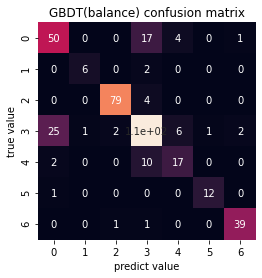

In [ ]:
# confusion matrix
matrix = confusion_matrix(y_test, pred_GBDT_bal)
sns.heatmap(matrix, square=True, annot=True, cbar=False)
plt.xlabel("predict value")
plt.ylabel("true value")
plt.title("GBDT(balance) confusion matrix")
plt.show()

In [ ]:
print("report:\n",
      classification_report(y_test, pred_GBDT_bal,
                            target_names = list_defectType))

report:
               precision    recall  f1-score   support

      Pastry       0.64      0.69      0.67        72
   Z_Scratch       0.86      0.75      0.80         8
    K_Scatch       0.96      0.95      0.96        83
      Stains       0.76      0.74      0.75       143
   Dirtiness       0.63      0.59      0.61        29
       Bumps       0.92      0.92      0.92        13
Other_Faults       0.93      0.95      0.94        41

    accuracy                           0.79       389
   macro avg       0.81      0.80      0.81       389
weighted avg       0.80      0.79      0.79       389



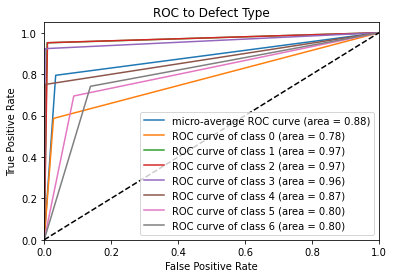

In [ ]:
# ROC curve of GBDT with SMOTE
pred_GBDT_bal_label = label_binarize(pred_GBDT_bal, classes = list_defectType)

n_classes = 7
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):  # one vs rest 計算每個類別的TPR/FPR以及AUC
    fpr[i], tpr[i], _ = roc_curve(y_test_label[:, i], pred_GBDT_bal_label[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_label.ravel(), pred_GBDT_bal_label.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) 

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC to Defect Type')
plt.legend(loc="lower right")
plt.show()

由結果觀察到 GBDT 不管是在 imbalanced data 和 balanced data上，表現皆優於 Random Forest；

而 GBDT 本身在兩資料集的準確率和 ROC curve 十分接近，不過可以看到 balanced dataset 在 macro average（偏向整體評估）的表現略優於 imbalanced data

## 參考資料
[1] [一文看懂決策樹-Decision tree（3個步驟+3種典型演算法+10個優缺點)](https://www.gushiciku.cn/pl/pmfE/zh-tw)

[2] [多分類模型Accuracy, Precision, Recall和F1-score的超級無敵深入探討](https://zhuanlan.zhihu.com/p/147663370)

[3] [[多分類]ROC曲線](https://blog.zhujian.life/posts/48526d13.html)

[4] [SMOTE + ENN : 解決數據不平衡建模的採樣方法](https://medium.com/%E6%95%B8%E5%AD%B8-%E4%BA%BA%E5%B7%A5%E6%99%BA%E6%85%A7%E8%88%87%E8%9F%92%E8%9B%87/smote-enn-%E8%A7%A3%E6%B1%BA%E6%95%B8%E6%93%9A%E4%B8%8D%E5%B9%B3%E8%A1%A1%E5%BB%BA%E6%A8%A1%E7%9A%84%E6%8E%A1%E6%A8%A3%E6%96%B9%E6%B3%95-cdb6324b711e)

[5] [用 Python 實作 CART 及 Random Forest](https://johnny-chuang.medium.com/cart-randomforest-88e7139e035c)

[6] [Random Forest in Python](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0)

# 3. Deep Learning

`註：此題在 colab 上執行`

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, SGD

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings('ignore')

## (a) CNN investigation

Investigate the effects of changing “PARAMETERS” such as learning rates, momentum, # of hidden/convolutional layers, dropout rate, etc.

Show the numerical results and “DIAGRAM” from different perspectives (e.g. accuracy, F1-score, convergence time, error of training data, error of testing data, etc.).

In [ ]:
# directory of train data
dir_train = '/content/gdrive/MyDrive/MDS_Assignment3/casting_data/train/' # todo: 印一個 file path tree
dir_train_def = dir_train + 'def_front/'  # Class label: Defective
dir_train_ok = dir_train + 'ok_front/'    # Class label: OK

# directory of test data
dir_test = '/content/gdrive/MyDrive/MDS_Assignment3/casting_data/test/'
dir_test_def = dir_test + 'def_front/'  # Class label: Defective
dir_test_ok = dir_test + 'ok_front/'    # Class label: OK

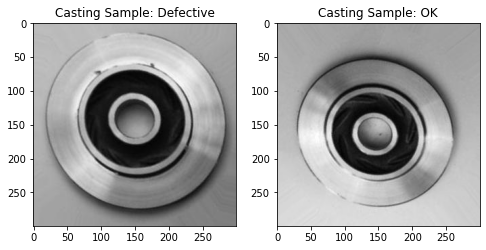

In [ ]:
# samples of defective and non-defective casting
fig, axes = plt.subplots(1, 2, figsize=(8,4))
sample_def = plt.imread(dir_train_def+os.listdir(dir_train_def)[0])
sample_ok = plt.imread(dir_train_ok+os.listdir(dir_train_ok)[0])
axes[0].imshow(sample_def)
axes[1].imshow(sample_ok)
axes[0].set_title('Casting Sample: Defective')
axes[1].set_title('Casting Sample: OK')
axes[0].grid(False)
axes[1].grid(False)
plt.show()

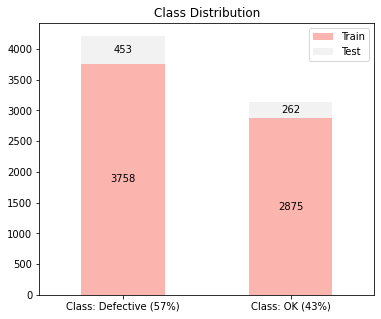

In [ ]:
# Create dataframe of class distribution
n_train = [len(os.listdir(dir_train_def)), len(os.listdir(dir_train_ok))]
n_test = [len(os.listdir(dir_test_def)), len(os.listdir(dir_test_ok))]
dist_df = pd.DataFrame(
    data=[n_train, n_test],
    columns=['Defective', 'OK'],
    index=['Train', 'Test'])

# visualize class distribution
ax = dist_df.T.plot(kind = 'bar', stacked = True, rot = 0, figsize = (6,5), cmap='Pastel1')  # create stacked graph
ax.set_title('Class Distribution')
for bar in ax.patches:
    ax.text(bar.get_x()+bar.get_width()-0.25,  # set number positionX
            bar.get_y()+bar.get_height()/2,  # set number positionY
            int(bar.get_height()),
            ha='center', va='center')
    
pct_def = 100*dist_df['Defective'].values.sum()/dist_df.values.sum()  # percentage of class Defective
pct_ok = 100-pct_def  # percentage of class OK

ax.set_xticklabels([f'Class: Defective ({pct_def:.0f}%)',
                    f'Class: OK ({pct_ok:.0f}%)'])
plt.show()

由於 Defective 與 OK 兩種 class 數量差不多 (6:4)，直接開始資料前處理。

### Data Preprocessing

資料前處理將影像轉為灰階， function 與參數如下：

- flow_from_directory(): used on the data generators for each of train/ and test/ directories

- Arguments for data generation:

  - target_size: image is 300×300 px
  - color_mode: 'grayscale' to convert images as having 1 channel
  - classes: classes mapping, 0 -> OK, 1 -> Defective
  - class_mode: 'binary' since there are two classes
  - batch_size: fixed at 64

In [ ]:
# define instances of ImageDataGenerator
train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # reserve 20% data for validation
test_gen = ImageDataGenerator(rescale=1./255)

# specify parameters/arguments for data generation
img_size, batch_size, rand_seed = (300, 300), 64, 0
arg_train = {'target_size': img_size,
             'color_mode': 'grayscale',
             'classes': {'ok_front': 0,
                         'def_front': 1},
             'class_mode': 'binary',
             'batch_size': batch_size,
             'seed': rand_seed}
arg_test = {'target_size': img_size,
            'color_mode': 'grayscale',
            'classes': {'ok_front': 0,
                        'def_front': 1},
            'class_mode': 'binary',
            'batch_size': batch_size,
            'seed': rand_seed,
            'shuffle': False}

# generate data by iterating through directories
train_set = train_gen.flow_from_directory(directory=dir_train, subset='training', **arg_train)  # 將 arg_train 打包成 dictionary
valid_set = train_gen.flow_from_directory(directory=dir_train, subset='validation', **arg_train)
test_set = test_gen.flow_from_directory(directory=dir_test, **arg_test)

Found 5307 images belonging to 2 classes.
Found 1326 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


### Model Building

關於常見的 CNN model 如 LeNet-5, VGG-16, Inception-v3, ResNet-50 可以參照 [Illustrated: 10 CNN Architectures](https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d)，其中滿多模型有現成套件可用，而這次作業會應用 VGG 的概念（3x3 conv. layers & 2x2 max-pooling layers）來延伸。

剛開始會先用一個簡單的 CNN model 當作 base，之後調整 learning rate, dropout rate, layer 數量以及 optimizer 中的 momentum 並比較結果

<img src="https://cezannec.github.io/assets/cnn_intro/CNN_ex.png" alt="CNN simpleg" width="500"/>

### basic model
參考簡單的 CNN 模型，建立一個 basic model 架構如下：
1. First convolutional layer: 用 32 張 3x3 的 kernel，strides 設為 2
  - padding 設為 same，填充照片邊緣盡量不影響原始訊息
  - 詳細的filter size、kernel size 以及 strides 是如何影響 feature map size 可以看參考來源[2]。
2. First pooling layer: 用 2x2 的 max-pooling，strides 設為 2
3. Second convolutional layer: 跟第一層 convolutional layer 一樣，但只用 16 張 filters
4. Second pooling layer: 跟第一層 pooling layer 一樣
5. Flattening: 將二維 pixel values 轉為一維，準備餵進 fully-connected layer
6. First dense layer + Dropout:
  - 128 units and 1 bias unit
  - Dropout of rate 20% 避免 overfitting
7. Second dense layer + Dropout: 
  - 64 units and 1 bias unit
  - Dropout of rate 20% 避免 overfitting
8. Output layer: 單一 unit 且 activation function 使用 sigmoid，因為 binary classification 需要的預測結果是 0 或 1。除了 output layer，其餘每層激活函數都用 ReLU(Rectified Linear Unit) 
- Relu

  Activation function Relu (Rectified Linear Unit，線性整流函數）讓我們定義的類神經網路可以更加活化學習，避免像是線性函數一樣較為死板。相較於其他的活化函數（如 sigmoid、tanh...），其優點包括：較能解決梯度消失問題、節省資源、比較接近生物模型（也就是我們大腦的思考模式。）

In [ ]:
IMAGE_SIZE = (300, 300)

# Define basic CNN model architecture
model = Sequential(
    [
        # First convolutional layer
        Conv2D(filters = 32,
               kernel_size = 3,
               strides = 2,
               padding = 'same',
               activation = 'relu',
               input_shape = IMAGE_SIZE + (1, )),
        
        # First pooling layer
        MaxPooling2D(pool_size = 2, strides = 2),
        
        # Second convolutional layer
        Conv2D(filters = 16,
               kernel_size = 3,
               strides = 2,
               padding = 'same',
               activation = 'relu'),
        
        # Second pooling layer
        MaxPooling2D(pool_size = 2, strides = 2),
        
        # Flattening
        Flatten(),
        
        # Fully-connected layer
        Dense(128, activation = 'relu'),
        Dropout(rate = 0.2),
        
        Dense(64, activation = 'relu'),
        Dropout(rate = 0.2),
        
        Dense(1, activation = 'sigmoid')
    ]
)

# Compile model
model.compile(
    optimizer = SGD(learning_rate=0.001),  # Default lr
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Display summary of model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 19, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 5776)              0         
                                                                 
 dense (Dense)               (None, 128)               7

#### epoch, batch size and iteration
在進行訓練之前，先瞭解何謂 epoch, batch size, iteration 等名詞

- Batch size: 決定一次訓練的樣本數目，e.g. Batch size = 1 就是隨機抽樣訓練的意思。
Batch size 的選擇是為了在 storage&efficiency 之間尋找最佳平衡，越大越需要記憶體空間。
- Epoch: 等同於演算法（模型）看過所有 traning data 一遍，
- Iteration: 每次傳遞一個 batch 的資料進去神經網路，就是完成一個迭代。在神經網路指的是完成一次 forward pass 和 backward pass。所以 batch size * number of iterations = epoch
- Epoch 和 Iteration 的不同：
  - One epoch includes all the training examples
  - One iteration includes only one batch of training examples
- 範例
if you have 2,000 images and use a batch size of 10 an epoch consists of 2,000 images / (10 images / step) = 200 steps.

In [ ]:
n_epochs = 30  # 每一次 epoch 會有 batch_size × steps_per_epoch 張圖片被輸入到 CNN model

In [ ]:
%%time

# Fit model using train set and validation set
# best model will be automatically saved if the current val_loss is lower than the previous one
checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/cnn_casting_inspection_model.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")

model.fit(
    train_set,
    validation_data = valid_set,
    epochs = n_epochs,
    callbacks = checkpoint,
    verbose=1)

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5568
Epoch 00001: val_loss improved from inf to 0.68874, saving model to /content/gdrive/MyDrive/cnn_casting_inspection_model.hdf5
83/83 [==============================] - 82s 971ms/step - loss: 0.6910 - accuracy: 0.5568 - val_loss: 0.6887 - val_accuracy: 0.5664
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.5604
Epoch 00002: val_loss improved from 0.68874 to 0.68672, saving model to /content/gdrive/MyDrive/cnn_casting_inspection_model.hdf5
83/83 [==============================] - 82s 989ms/step - loss: 0.6881 - accuracy: 0.5604 - val_loss: 0.6867 - val_accuracy: 0.5664
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.5664
Epoch 00003: val_loss improved from 0.68672 to 0.68484, saving model to /content/gdrive/MyDrive/cnn_casting_inspection_model.hdf5
83/83 [==============================] - 81s 970ms/step - loss: 0.68

The "accuracy" above means model accuracy on training data, and the "val_accuracy" means model accuracy on validation data.

在這個例子中，我的模型 accuracy 為 67.06%，測試集的 accuracy 則是 71.72%

接下來要繪製出模型訓練過程中 accuracy 與 loss 的走勢。

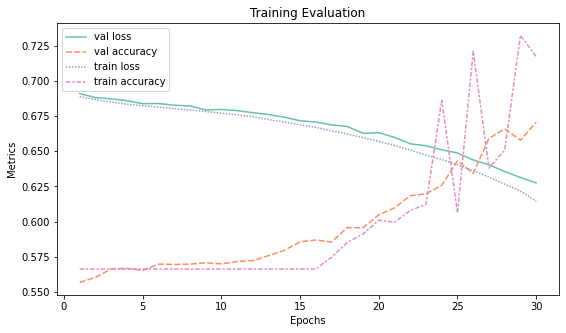

In [ ]:
# Plot learning curve from model history
plt.subplots(figsize = (9,5))
model_history = pd.DataFrame(model.history.history, index = range(1, 1+len(model.history.epoch)))

sns.lineplot(data = model_history, palette='Set2')
plt.title("Training Evaluation")
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

透過這張圖，搭配在網路上找到的建議，可以大致了解訓練模型的過程中可能發生了哪些問題：

- train loss 不斷下降，test loss不斷下降，說明模型仍在學習;（最好的）
- train loss 不斷下降，test loss趨於不變，說明模型過擬合;（max pool或者正則化）
- train loss 趨於不變，test loss不斷下降，說明數據集有問題;（檢查dataset）
- train loss 趨於不變，test loss趨於不變，說明模型學習遇到瓶頸，需要減小學習率或批量數目
- train loss 不斷上升，test loss不斷上升，說明網絡結構設計不當，訓練超參數設置不當，數據集經過清洗等問題。（最不好的情況）

由於這次訓練loss持續下降，說明模型的方向是好的，拿來預測 test dataset並觀察。

In [ ]:
# Load saved model
best_model = load_model("/content/gdrive/MyDrive/cnn_casting_inspection_model.hdf5")

# Make predictions on images in the test set
y_true = test_set.classes[test_set.index_array]
y_pred_prob = best_model.predict(test_set, verbose=1)
threshold = 0.5
y_pred = (y_pred_prob >= threshold).reshape(-1,)

12/12 [==============================] - 4s 330ms/step


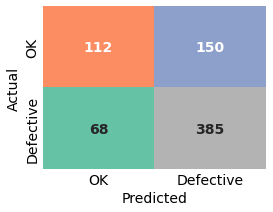

In [ ]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Set2')
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Actual', size=14)
plt.xlabel('Predicted', size=14)
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.43      0.51       262
           1       0.72      0.85      0.78       453

    accuracy                           0.70       715
   macro avg       0.67      0.64      0.64       715
weighted avg       0.68      0.70      0.68       715



### model_2: add convolutional & pooling layer
根據 basic model，嘗試在前面多加一個block（conv+pooling）

In [ ]:
IMAGE_SIZE = (300, 300)

# Define basic CNN model architecture
model_2 = Sequential(
    [
        # First convolutional layer
        Conv2D(filters = 64,  # adding one block before basic model
               kernel_size = 3,
               strides = 2,
               padding = 'same',
               activation = 'relu',
               input_shape = IMAGE_SIZE + (1, )),
        
        # First pooling layer
        MaxPooling2D(pool_size = 2, strides = 2),
        
        # Second convolutional layer
        Conv2D(filters = 32,
               kernel_size = 3,
               strides = 2,
               padding = 'same',
               activation = 'relu',
               input_shape = IMAGE_SIZE + (1, )),
        
        # Second pooling layer
        MaxPooling2D(pool_size = 2, strides = 2),
        
        # Third convolutional layer
        Conv2D(filters = 16,
               kernel_size = 3,
               strides = 2,
               padding = 'same',
               activation = 'relu'),
        
        # Third pooling layer
        MaxPooling2D(pool_size = 2, strides = 2),
        
        # Flattening
        Flatten(),
        
        # Fully-connected layer
        Dense(128, activation = 'relu'),
        Dropout(rate = 0.2),
        
        Dense(64, activation = 'relu'),
        Dropout(rate = 0.2),
        
        Dense(1, activation = 'sigmoid')
    ]
)

# Compile model
model_2.compile(
    optimizer = SGD(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Display summary of model architecture
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 64)      640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 38, 38, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 19, 19, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 16)        4624      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 16)        

#### Early stopping
在跑第二種模型前，為了避免模型在 loss 值沒有改善的情況下繼續計算會花費過多時間，在此使用 early stopping 來確保 val_loss 會在 5 個 epochs 都沒有進步時提前終止程式。

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)  # early stop training when val_loss didn't improve

In [ ]:
%%time

# Fit model using train set and validation set
# best model will be automatically saved if the current val_loss is lower than the previous one
checkpoint_2 = ModelCheckpoint("/content/gdrive/MyDrive/cnn_casting_inspection_model_2.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")

model_2.fit(
    train_set,
    validation_data = valid_set,
    epochs = n_epochs,
    callbacks = [checkpoint_2, earlyStopping],
    verbose=1)

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.6838 - accuracy: 0.5666
Epoch 00001: val_loss improved from inf to 0.68317, saving model to /content/gdrive/MyDrive/cnn_casting_inspection_model_2.hdf5
83/83 [==============================] - 128s 2s/step - loss: 0.6838 - accuracy: 0.5666 - val_loss: 0.6832 - val_accuracy: 0.5664
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.5668
Epoch 00002: val_loss improved from 0.68317 to 0.68305, saving model to /content/gdrive/MyDrive/cnn_casting_inspection_model_2.hdf5
83/83 [==============================] - 128s 2s/step - loss: 0.6841 - accuracy: 0.5668 - val_loss: 0.6831 - val_accuracy: 0.5664
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.5666
Epoch 00003: val_loss improved from 0.68305 to 0.68291, saving model to /content/gdrive/MyDrive/cnn_casting_inspection_model_2.hdf5
83/83 [==============================] - 133s 2s/step - loss: 0.68

沒想到在多加一層 convolution 與 max pooling 後，雖然損失值在每次 epoch 皆有進步，但最後的準確率和損失值都較 basic model 差，接著觀察其 learning curve:

In [ ]:
# Plot learning curve from model history
plt.subplots(figsize = (9,5))
model_2_history = pd.DataFrame(model_2.history.history, index = range(1, 1+len(model_2.history.epoch)))

sns.lineplot(data = model_2_history, palette='Set2')
plt.title("Training Evaluation")
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

可以看到模型訓練時 accuracy loss 都沒有什麼變化，如同一灘死水

In [ ]:
# Load saved model
best_model_2 = load_model("/content/gdrive/MyDrive/cnn_casting_inspection_model_2.hdf5")

# Make predictions on images in the test set
y_pred_prob_2 = best_model_2.predict(test_set, verbose=1)
y_pred_2 = (y_pred_prob_2 >= threshold).reshape(-1,)

12/12 [==============================] - 5s 418ms/step


In [ ]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(confusion_matrix(y_true, y_pred_2), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Set2')
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Actual', size=14)
plt.xlabel('Predicted', size=14)
plt.show()

In [ ]:
print(classification_report(y_true, y_pred_2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       262
           1       0.63      1.00      0.78       453

    accuracy                           0.63       715
   macro avg       0.32      0.50      0.39       715
weighted avg       0.40      0.63      0.49       715



由 confusion matrix 可以看出模型全部都預測為 Defective，推測模型根本沒在學習QQ，雖然準確率有 63%，大概也是因為它全部猜 Defective。

在此保留多加的 convolutional 與 pooling layer，調整 dropout 並觀察其成效。

### model_3: adjust drop out
drop out 由原本的 0.2 調整為 0.5

In [ ]:
IMAGE_SIZE = (300, 300)

# Define basic CNN model architecture
model_3 = Sequential(
    [
        # First convolutional layer
        Conv2D(filters = 64,
               kernel_size = 3,
               strides = 2,
               padding = 'same',
               activation = 'relu',
               input_shape = IMAGE_SIZE + (1, )),
        
        # First pooling layer
        MaxPooling2D(pool_size = 2, strides = 2),
        
        # Second convolutional layer
        Conv2D(filters = 32,
               kernel_size = 3,
               strides = 2,
               padding = 'same',
               activation = 'relu',
               input_shape = IMAGE_SIZE + (1, )),
        
        # Second pooling layer
        MaxPooling2D(pool_size = 2, strides = 2),
        
        # Third convolutional layer
        Conv2D(filters = 16,
               kernel_size = 3,
               strides = 2,
               padding = 'same',
               activation = 'relu'),
        
        # Third pooling layer
        MaxPooling2D(pool_size = 2, strides = 2),
        
        # Flattening
        Flatten(),
        
        # Fully-connected layer
        Dense(128, activation = 'relu'),
        Dropout(rate = 0.5),
        
        Dense(64, activation = 'relu'),
        Dropout(rate = 0.5),
        
        Dense(1, activation = 'sigmoid')
    ]
)

# Compile model
model_3.compile(
    optimizer = SGD(learning_rate=0.001),  # Default lr
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Display summary of model architecture
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 64)      640       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 38, 38, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 19, 19, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 16)        4624      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 16)        

In [ ]:
%%time

# Fit model using train set and validation set
# best model will be automatically saved if the current val_loss is lower than the previous one
checkpoint_3 = ModelCheckpoint("/content/gdrive/MyDrive/cnn_casting_inspection_model_3.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")

model_3.fit(
    train_set,
    validation_data = valid_set,
    epochs = n_epochs,
    callbacks = [checkpoint_3, earlyStopping],
    verbose=1)

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.5431
Epoch 00001: val_loss improved from inf to 0.68955, saving model to /content/gdrive/MyDrive/cnn_casting_inspection_model_3.hdf5
83/83 [==============================] - 134s 2s/step - loss: 0.6905 - accuracy: 0.5431 - val_loss: 0.6895 - val_accuracy: 0.5664
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.5510
Epoch 00002: val_loss improved from 0.68955 to 0.68895, saving model to /content/gdrive/MyDrive/cnn_casting_inspection_model_3.hdf5
83/83 [==============================] - 132s 2s/step - loss: 0.6900 - accuracy: 0.5510 - val_loss: 0.6890 - val_accuracy: 0.5664
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5525
Epoch 00003: val_loss improved from 0.68895 to 0.68844, saving model to /content/gdrive/MyDrive/cnn_casting_inspection_model_3.hdf5
83/83 [==============================] - 130s 2s/step - loss: 0.68

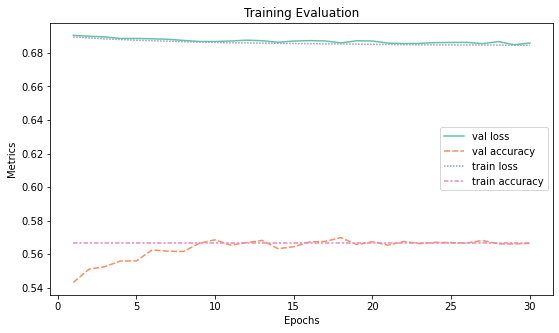

In [ ]:
# Plot learning curve from model history
plt.subplots(figsize = (9,5))
model_3_history = pd.DataFrame(model_3.history.history, index = range(1, 1+len(model_3.history.epoch)))

sns.lineplot(data = model_3_history, palette='Set2')
plt.title("Training Evaluation")
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

這下子不只 accuracy 下降，連 loss 都上升

In [ ]:
# Load saved model
best_model_3 = load_model("/content/gdrive/MyDrive/cnn_casting_inspection_model_3.hdf5")

# Make predictions on images in the test set
y_pred_prob_3 = best_model_3.predict(test_set, verbose=1)
y_pred_3 = (y_pred_prob_3 >= threshold).reshape(-1,)

12/12 [==============================] - 5s 419ms/step


In [ ]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(confusion_matrix(y_true, y_pred_3), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Set2')
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Actual', size=14)
plt.xlabel('Predicted', size=14)
plt.show()

In [ ]:
print(classification_report(y_true, y_pred_3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       262
           1       0.63      1.00      0.78       453

    accuracy                           0.63       715
   macro avg       0.32      0.50      0.39       715
weighted avg       0.40      0.63      0.49       715



#### dropout
問題：由於 dropout 是一種對抗 overfitting 的方法，當模型都還沒有 fit 時就把 dropout 調大似乎是於事無補，甚至讓模型效能更差。

於是把 layer 調回到一開始的架構，並保留 dropout=0.5 的設定。

接下來為了加速訓練，將 learning rate 從 0.001 改為 0.1

### model_4: adjust learning rate
將 basic model 的 learning rate 改為 0.1

In [ ]:
IMAGE_SIZE = (300, 300)

# Define basic CNN model architecture
model_4 = Sequential(
    [
        # First convolutional layer
        Conv2D(filters = 32,
               kernel_size = 3,
               strides = 2,
               padding = 'same',
               activation = 'relu',
               input_shape = IMAGE_SIZE + (1, )),
        
        # First pooling layer
        MaxPooling2D(pool_size = 2, strides = 2),
        
        # Second convolutional layer
        Conv2D(filters = 16,
               kernel_size = 3,
               strides = 2,
               padding = 'same',
               activation = 'relu'),
        
        # Second pooling layer
        MaxPooling2D(pool_size = 2, strides = 2),
        
        # Flattening
        Flatten(),
        
        # Fully-connected layer
        Dense(128, activation = 'relu'),
        Dropout(rate = 0.5),
        
        Dense(64, activation = 'relu'),
        Dropout(rate = 0.5),
        
        Dense(1, activation = 'sigmoid')
    ]
)

# Compile model
model_4.compile(
    optimizer = SGD(learning_rate=0.1),
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Display summary of model architecture
model_4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 38, 38, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 19, 19, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 5776)              0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [ ]:
%%time

# Fit model using train set and validation set
# best model will be automatically saved if the current val_loss is lower than the previous one
checkpoint_4 = ModelCheckpoint("/content/gdrive/MyDrive/cnn_casting_inspection_model_4.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")

model_4.fit(
    train_set,
    validation_data = valid_set,
    epochs = n_epochs,
    callbacks = [checkpoint_4, earlyStopping],
    verbose=1)

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.6799 - accuracy: 0.5785
Epoch 00001: val_loss improved from inf to 0.64516, saving model to /content/gdrive/MyDrive/cnn_casting_inspection_model_4.hdf5
83/83 [==============================] - 84s 998ms/step - loss: 0.6799 - accuracy: 0.5785 - val_loss: 0.6452 - val_accuracy: 0.7391
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.6343 - accuracy: 0.6329
Epoch 00002: val_loss improved from 0.64516 to 0.54127, saving model to /content/gdrive/MyDrive/cnn_casting_inspection_model_4.hdf5
83/83 [==============================] - 82s 985ms/step - loss: 0.6343 - accuracy: 0.6329 - val_loss: 0.5413 - val_accuracy: 0.7360
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.5961 - accuracy: 0.6731
Epoch 00003: val_loss did not improve from 0.54127
83/83 [==============================] - 80s 967ms/step - loss: 0.5961 - accuracy: 0.6731 - val_loss: 0.5610 - val_accuracy: 0.7617
Epoch 4/30


In [ ]:
# Plot learning curve from model history
plt.subplots(figsize = (9,5))
model_4_history = pd.DataFrame(model_4.history.history, index = range(1, 1+len(model_4.history.epoch)))

sns.lineplot(data = model_4_history, palette='Set2')
plt.title("Training Evaluation")
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

In [ ]:
# Load saved model
best_model_4 = load_model("/content/gdrive/MyDrive/cnn_casting_inspection_model_4.hdf5")

# Make predictions on images in the test set
y_pred_prob_4 = best_model_4.predict(test_set, verbose=1)
y_pred_4 = (y_pred_prob_4 >= threshold).reshape(-1,)

12/12 [==============================] - 5s 357ms/step


In [ ]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(confusion_matrix(y_true, y_pred_4), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Set2')
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Actual', size=14)
plt.xlabel('Predicted', size=14)
plt.show()

In [ ]:
print(classification_report(y_true, y_pred_4))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       262
           1       1.00      0.97      0.98       453

    accuracy                           0.98       715
   macro avg       0.97      0.98      0.98       715
weighted avg       0.98      0.98      0.98       715



#### learning rate
<img src="https://raw.githubusercontent.com/terrifyzhao/terrifyzhao.github.io/master/assets/img/2019-05-23-%E5%AD%A6%E4%B9%A0%E7%8E%87Learning%20rate/pic1.jpg" alt="lr" width="300"/>

learning rate 過大會導致模型難以收斂，過小的時候會收斂速度過慢

可以看到 learning rate 調為 0.1 之後模型有進步，learning curve 看起來也比較正常了。

但是 accuracy 和 loss 震盪的幅度太過劇烈，且在最後的部分 val_loss 有反彈的現象(might be overfitting)，因此下個模型調整預計加入 momentum 並觀察其效果。 

### model_5: adding momentum
由於 model_4 震盪有點大，在 optimizer(這裡使用SGD) 加入 momentum=0.5 並觀察其成效

#### SGD and momentum

- SGD：這次作業使用的 optimizer，是最單純的 gradient decent 方法，找出參數的梯度(利用微分的方法)，往梯度的方向去更新參數(weight)。

- Momentum：Momentum 是「運動量」的意思，此優化器為模擬物理動量的概念，在同方向的維度上學習速度會變快，方向改變的時候學習速度會變慢。因此在 SGD 中加入 momentum 的參數，可以抑制震盪並加快模型收斂。

In [ ]:
IMAGE_SIZE = (300, 300)

# Define basic CNN model architecture
model_5 = Sequential(
    [
        # First convolutional layer
        Conv2D(filters = 32,
               kernel_size = 3,
               strides = 2,
               padding = 'same',
               activation = 'relu',
               input_shape = IMAGE_SIZE + (1, )),
        
        # First pooling layer
        MaxPooling2D(pool_size = 2, strides = 2),
        
        # Second convolutional layer
        Conv2D(filters = 16,
               kernel_size = 3,
               strides = 2,
               padding = 'same',
               activation = 'relu'),
        
        # Second pooling layer
        MaxPooling2D(pool_size = 2, strides = 2),
        
        # Flattening
        Flatten(),
        
        # Fully-connected layer
        Dense(128, activation = 'relu'),
        Dropout(rate = 0.5),
        
        Dense(64, activation = 'relu'),
        Dropout(rate = 0.5),
        
        Dense(1, activation = 'sigmoid')
    ]
)

# Compile model
model_5.compile(
    optimizer = SGD(learning_rate=0.1, momentum=0.5),  # adding momentum
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Display summary of model architecture
model_5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 38, 38, 16)        4624      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 19, 19, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 5776)              0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [ ]:
%%time

# Fit model using train set and validation set
# best model will be automatically saved if the current val_loss is lower than the previous one
checkpoint_5 = ModelCheckpoint("/content/gdrive/MyDrive/cnn_casting_inspection_model_5.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")
model_5.fit(
    train_set,
    validation_data = valid_set,
    epochs = n_epochs,
    callbacks = [checkpoint_5, earlyStopping],
    verbose=1)

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.6775 - accuracy: 0.5702
Epoch 00001: val_loss improved from inf to 0.60659, saving model to /content/gdrive/MyDrive/cnn_casting_inspection_model_5.hdf5
83/83 [==============================] - 87s 1s/step - loss: 0.6775 - accuracy: 0.5702 - val_loss: 0.6066 - val_accuracy: 0.7428
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 0.6260 - accuracy: 0.6480
Epoch 00002: val_loss did not improve from 0.60659
83/83 [==============================] - 84s 1s/step - loss: 0.6260 - accuracy: 0.6480 - val_loss: 0.6748 - val_accuracy: 0.5664
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 0.6445 - accuracy: 0.6252
Epoch 00003: val_loss did not improve from 0.60659
83/83 [==============================] - 81s 969ms/step - loss: 0.6445 - accuracy: 0.6252 - val_loss: 0.6765 - val_accuracy: 0.6094
Epoch 4/30
83/83 [==============================] - ETA: 0s - loss: 0.6239 - accuracy: 0.6458
Epoc

In [ ]:
# Plot learning curve from model history
plt.subplots(figsize = (9,5))
model_5_history = pd.DataFrame(model_5.history.history, index = range(1, 1+len(model_5.history.epoch)))

sns.lineplot(data = model_5_history, palette='Set2')
plt.title("Training Evaluation")
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

In [ ]:
# Load saved model
best_model_5 = load_model("/content/gdrive/MyDrive/cnn_casting_inspection_model_5.hdf5")

# Make predictions on images in the test set
y_pred_prob_5 = best_model_5.predict(test_set, verbose=1)
y_pred_5 = (y_pred_prob_5 >= threshold).reshape(-1,)

12/12 [==============================] - 180s 16s/step


In [ ]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(confusion_matrix(y_true, y_pred_5), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Set2')
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Actual', size=14)
plt.xlabel('Predicted', size=14)
plt.show()

In [ ]:
print(classification_report(y_true, y_pred_5))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       262
           1       1.00      0.97      0.98       453

    accuracy                           0.98       715
   macro avg       0.97      0.98      0.97       715
weighted avg       0.98      0.98      0.98       715



可由 learning curve 看到加入 momentum 後的模型較為平滑(smooth)，也說明了 momentum 確實可以抑制震盪，加快收斂

### model_6: Final round
根據 model_5 修改，在前一輪中準確率有不錯的表現，但其實將 learning rate 調為 0.1 只是為了觀察變化，在一般情況中不會設這麼高，所以最後一輪模型的訓練會再將 learning rate 下修一點，並執行 25 epochs 就好。

In [ ]:
IMAGE_SIZE = (300, 300)

# Define basic CNN model architecture
model_6 = Sequential(
    [
        # First convolutional layer
        Conv2D(filters = 32,
               kernel_size = 3,
               strides = 2,
               padding = 'same',
               activation = 'relu',
               input_shape = IMAGE_SIZE + (1, )),
        
        # First pooling layer
        MaxPooling2D(pool_size = 2, strides = 2),
        
        # Second convolutional layer
        Conv2D(filters = 16,
               kernel_size = 3,
               strides = 2,
               padding = 'same',
               activation = 'relu'),
        
        # Second pooling layer
        MaxPooling2D(pool_size = 2, strides = 2),
        
        # Flattening
        Flatten(),
        
        # Fully-connected layer
        Dense(128, activation = 'relu'),
        Dropout(rate = 0.5),
        
        Dense(64, activation = 'relu'),
        Dropout(rate = 0.5),
        
        Dense(1, activation = 'sigmoid')
    ]
)

# Compile model
model_6.compile(
    optimizer = SGD(learning_rate=0.05, momentum=0.5),
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Display summary of model architecture
model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 19, 19, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 5776)              0         
                                                                 
 dense (Dense)               (None, 128)               7

In [ ]:
%%time

# Fit model using train set and validation set
# best model will be automatically saved if the current val_loss is lower than the previous one
checkpoint_6 = ModelCheckpoint("/content/gdrive/MyDrive/cnn_casting_inspection_model_6.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")

model_6.fit(
    train_set,
    validation_data = valid_set,
    epochs = 25,  # only run 25 epochs
    callbacks = [checkpoint_6, earlyStopping],
    verbose=1)

Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.5687
Epoch 00001: val_loss improved from inf to 0.66368, saving model to /content/gdrive/MyDrive/cnn_casting_inspection_model_6.hdf5
83/83 [==============================] - 86s 1s/step - loss: 0.6833 - accuracy: 0.5687 - val_loss: 0.6637 - val_accuracy: 0.5694
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 0.6202 - accuracy: 0.6529
Epoch 00002: val_loss improved from 0.66368 to 0.64385, saving model to /content/gdrive/MyDrive/cnn_casting_inspection_model_6.hdf5
83/83 [==============================] - 84s 1s/step - loss: 0.6202 - accuracy: 0.6529 - val_loss: 0.6438 - val_accuracy: 0.6501
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 0.5440 - accuracy: 0.7068
Epoch 00003: val_loss improved from 0.64385 to 0.46506, saving model to /content/gdrive/MyDrive/cnn_casting_inspection_model_6.hdf5
83/83 [==============================] - 85s 1s/step - loss: 0.5440 

In [ ]:
# Plot learning curve from model history
plt.subplots(figsize = (9,5))
model_6_history = pd.DataFrame(model_6.history.history, index = range(1, 1+len(model_6.history.epoch)))

sns.lineplot(data = model_6_history, palette='Set2')
plt.title("Training Evaluation")
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

In [ ]:
# Load saved model
best_model_6 = load_model("/content/gdrive/MyDrive/cnn_casting_inspection_model_6.hdf5")

# Make predictions on images in the test set
y_pred_prob_6 = best_model_6.predict(test_set, verbose=1)
y_pred_6 = (y_pred_prob_6 >= threshold).reshape(-1,)

12/12 [==============================] - 5s 382ms/step


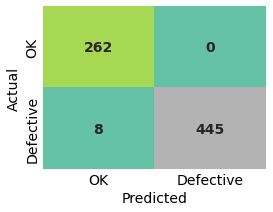

In [ ]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(confusion_matrix(y_true, y_pred_6), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Set2')
ax.set_xticklabels(['OK', 'Defective'])
ax.set_yticklabels(['OK', 'Defective'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Actual', size=14)
plt.xlabel('Predicted', size=14)
plt.show()

In [ ]:
print(classification_report(y_true, y_pred_6))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       262
           1       1.00      0.98      0.99       453

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



最後我們的模型 accuracy 來到 98.64%， 測試集則是 98.94%。

### Visualize result

#### Model Architecture

In [ ]:
# plot model architecture
plot_model(model_6, to_file='model_6_plot.png', show_shapes=True, show_layer_names=True, dpi=80)

#### Prediction on test images

In [ ]:
class_mapping = {0: 'OK', 1: 'Defective'}
images, labels = next(iter(test_set))
images = images.reshape(batch_size,*img_size)
fig, axes = plt.subplots(1, 4, figsize=(9, 4))
fig.suptitle('Prediction on Test Images', weight='bold', fontsize=14)
for ax, img, label in zip(axes.flat, images, labels):
    ax.imshow(img, cmap='gray')
    [[pred_prob]] = best_model_6.predict(img.reshape(1, *img_size, -1))
    pred_label = class_map[int(pred_prob>=threshold)]
    true_label = class_map[label]
    prob_class = 100*pred_prob if pred_label=='Defective' else 100*(1-pred_prob)
    ax.set_title(f'Actual: {true_label}', size=12)
    ax.set_xlabel(f'Predicted: {pred_label} ({prob_class:.2f}%)',
                  color='g' if pred_label==true_label else 'r')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
# misclassified prediction
misclassify_pred = np.nonzero(y_pred_6 != y_true)[0]

fig, axes = plt.subplots(2,4, figsize=(15,5))

for ax, batch_num, image_num in zip(axes.flat, misclassify_pred // batch_size, misclassify_pred % batch_size):
    images, labels = test_set[batch_num]
    img = images[image_num]
    ax.imshow(img.reshape(*img_size), cmap = "gray")
    
    true_label = class_mapping[labels[image_num]]
    [[pred_prob]] = best_model_6.predict(img.reshape(1, *img_size, -1))
    pred_label = class_mapping[int(pred_prob >= threshold)]
    
    prob_class = 100*pred_prob if pred_label == "Defect" else 100*(1-pred_prob)
    
    ax.set_title(f"Actual: {true_label}", fontsize=12)
    ax.set_xlabel(f"Predict: {pred_label} ({prob_class:.2f}%)",
                 color = "blue" if true_label == pred_label else "red")
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
fig.suptitle(f"Misclassified on Test Images ({len(misclassify_pred)} out of {len(y_true)})",
             fontsize=14, y=1.08, fontweight = "bold")
plt.show()

In [ ]:
# # Check current path
# print(os.getcwd())

/content


### 心得

雖然在機器學習領域有各式各樣的模型架構與超參數調整方法被提出，但做完這題，仍然覺得超參數的調整實在是一門學問（玄學）。往後如果有類似的實作題目，已經知道有哪些細節可以去嘗試跟注意，同時也在實作的過程中不斷提醒自己將過程紀錄得詳細一點，以便日後回來改良模型。

### 參考資料

[1] [Visual Inspection of Casting Products using CNN](https://www.kaggle.com/ginsaputra/visual-inspection-of-casting-products-using-cnn)

[2] [What is batch size, steps, iteration, and epoch in the neural network?](https://androidkt.com/batch-size-step-iteration-epoch-neural-network/)

[3] [卷積神經網路(Convolutional neural network, CNN): 卷積計算中的步伐(stride)和填充(padding)](https://chih-sheng-huang821.medium.com/%E5%8D%B7%E7%A9%8D%E7%A5%9E%E7%B6%93%E7%B6%B2%E8%B7%AF-convolutional-neural-network-cnn-%E5%8D%B7%E7%A9%8D%E8%A8%88%E7%AE%97%E4%B8%AD%E7%9A%84%E6%AD%A5%E4%BC%90-stride-%E5%92%8C%E5%A1%AB%E5%85%85-padding-94449e638e82)

[4] [TensorFlow中loss與val_loss、accuracy和val_accuracy含意](https://blog.csdn.net/qingfengxd1/article/details/107320580)

[5] [深度學習：CNN原理](https://cinnamonaitaiwan.medium.com/%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-cnn%E5%8E%9F%E7%90%86-keras%E5%AF%A6%E7%8F%BE-432fd9ea4935)

[6] [Casting Inspection with Data Augmentation (CNN)](https://www.kaggle.com/tomythoven/casting-inspection-with-data-augmentation-cnn)

# 4. Time-Series Prediction

## (a) Build LSTM model and show the prediction results via Time-series Nested Cross Validation

### Dataset

Using [**US Diesel Sales Price**](https://fred.stlouisfed.org/series/GASDESW) dataset(units: Dollars per Gallon) on [Fred](https://fred.stlouisfed.org/categories/32217), collected from U.S. Energy Information Administration.

The dataset which has 1447 records starting from 1994-03-21 to 2021-12-06 with weekly interval.

- LSTM:

  LSTM (Long-Short Term Memory) 是一種 RNN (循環神經網路)，跟一般深度神經網路不同，多了資料的方向性(時序關聯)，RNN 會將每一個隱藏層的結果儲存在記憶單元，並且當新的資料進來時，會考慮記憶單元的值去計算


  1. Input gate(it)
  2. Hidden state(ht) 
  3. Cell state(ct)
  4. Output gate(ot)
  5. Forget gate(ft)

  LSTM 內部除了 hidden state 還添加了 cell state 當作資訊庫，並建立了 forget gate 和 input gate 來控制哪些資訊要被遺忘或傳遞，還有 output gate 來決定資訊庫中的哪些資訊在當下最有用，要輸出給下一層的 hidden state。

- 為什麼  Time Series 問題不能用單純的 k-fold：

 若單純使用 k-fold，代表我們會用到未來的資料去預測以前的資料，在訓練 time series 相關模型時應避免這種 future-looking 的情形發生；且先後資料間會有一些短暫的相依，我們要盡量保留這些關係。

  Cross Validation on Time-series LSTM

 <img src="https://miro.medium.com/max/1084/1*qvdnPF8ETV9mFdMT0Y_BBA.png" alt="rolling" width="500"/>

 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.utils.vis_utils import plot_model

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

TensorFlow 1.x selected.
1.15.2


Using TensorFlow backend.


In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/MDS_Assignment3/GASDESW_2000-2021.csv")

In [ ]:
data = data.rename(columns = {'DATE': 'Date', 'GASDESW': 'Price'})

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1096 non-null   object 
 1   Price   1096 non-null   float64
dtypes: float64(1), object(1)
memory usage: 17.2+ KB


In [ ]:
data.isnull().any().any()  # missing value

False

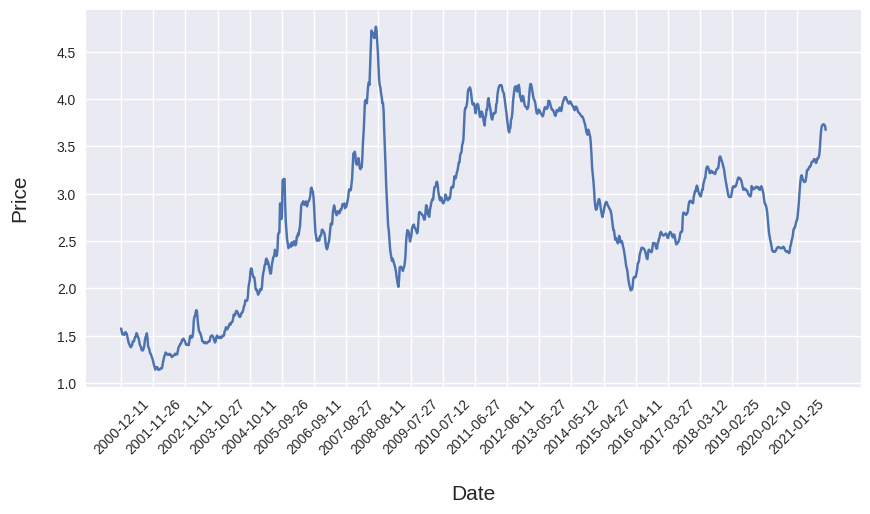

In [ ]:
# data visualization
plt.figure(figsize = (10,5), dpi=100)
plt.plot(data['Date'], data[['Price']])
plt.xticks(range(0, data.shape[0], 50), data['Date'].loc[::50], rotation=45)  # set axis x range and style
plt.xlabel('Date', fontsize=15, labelpad = 20)
plt.ylabel('Price', fontsize=15, labelpad = 20)
plt.show()

從上圖可以觀察到一些趨勢，例如圖上最高峰發生在 2008 年，當時發生金融危機，年底油價大跌。除此之外，全球石油供需從 2014 年開始逐漸失衡，到 2016 年美國解除石油出口禁令，以及 2019 年底的肺炎疫情爆發，各歷經了幾次油價下跌。

### Normalization

In [ ]:
# normailize databetween 0 and 1
df = data['Price'].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range = (0, 1))
df = scaler.fit_transform(df)

### Split data

In [ ]:
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train, test = df[0:train_size, :], df[train_size:len(df), :]

In [ ]:
print(f'Traning data\n {train[:10]}...\nlength:{len(train)}')
print(f'Testing data\n {test[:10]}...\nlength:{len(test)}')

Traning data
 [[0.12058499]
 [0.11175497]
 [0.10347682]
 [0.10540839]
 [0.10485651]
 [0.10182119]
 [0.10706402]
 [0.11009934]
 [0.10485651]
 [0.10430464]]...
length:767
Testing data
 [[0.39210817]
 [0.37913907]
 [0.38465784]
 [0.37996689]
 [0.37334437]
 [0.36865342]
 [0.37306843]
 [0.39072848]
 [0.38383002]
 [0.37472406]]...
length:329


In [ ]:
# # train the Scaler with training data and smooth data
# smoothing_size = 876//4  # operator//means divide and round down to integer

# # fit and transform training data(price)
# for di in range(0, 876, smoothing_size):
#     scaler.fit(train_price[di:di+smoothing_size,:])
#     train_price[di:di+smoothing_size,:] = scaler.transform(train_price[di:di+smoothing_size,:])

# # # normalize the last bit of remaining data -> 剛好整除
# # scaler.fit(train_price[di+smoothing_size:,:])
# # train_price[di+smoothing_size:,:] = scaler.transform(train_price[di+smoothing_size:,:])

### Build Dataset for training time-rolling Nested LSTM
為了進行 time-rolling 的 nested LSTM，在此定義函數用來建置訓練資料集

In [ ]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []  # Y 可以想像成未來的資料
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 8  # 拿前 n 期預測後 n 期
X_train, Y_train, X_test, Y_test = [],[],[],[]
X_train, Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test, Y_test=create_data_set(test, look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# # reshape both train and test data
# train_price = train_price.reshape(-1)

# # normalize on test data
# test_price = scaler.transform(test_price).reshape(-1)

### Model Building

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

在此引用 nested LSTM 的模型架構，詳細參數可參考：https://github.com/hannw/nlstm

In [ ]:
from __future__ import absolute_import
import warnings

from keras import backend as K
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.engine import Layer
from keras.engine import InputSpec
from keras.legacy import interfaces
from keras.layers import RNN
from keras.layers.recurrent import _generate_dropout_mask
from keras.layers import LSTMCell, LSTM


class NestedLSTMCell(Layer):

    def __init__(self, units, depth,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 cell_activation='linear',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 unit_forget_bias=False,
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 **kwargs):
        super(NestedLSTMCell, self).__init__(**kwargs)

        if depth < 1:
            raise ValueError("`depth` must be at least 1. For better performance, consider using depth > 1.")

        if implementation != 1:
            warnings.warn(
                "Nested LSTMs only supports implementation 2 for the moment. Defaulting to implementation = 2")
            implementation = 2

        self.units = units
        self.depth = depth
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.cell_activation = activations.get(cell_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.unit_forget_bias = unit_forget_bias

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.state_size = tuple([self.units] * (self.depth + 1))
        self._dropout_mask = None
        self._nested_recurrent_masks = None

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.kernels = []
        self.biases = []

        for i in range(self.depth):
            if i == 0:
                input_kernel = self.add_weight(shape=(input_dim, self.units * 4),
                                               name='input_kernel_%d' % (i + 1),
                                               initializer=self.kernel_initializer,
                                               regularizer=self.kernel_regularizer,
                                               constraint=self.kernel_constraint)
                hidden_kernel = self.add_weight(shape=(self.units, self.units * 4),
                                                name='kernel_%d' % (i + 1),
                                                initializer=self.recurrent_initializer,
                                                regularizer=self.recurrent_regularizer,
                                                constraint=self.recurrent_constraint)
                kernel = K.concatenate([input_kernel, hidden_kernel], axis=0)
            else:
                kernel = self.add_weight(shape=(self.units * 2, self.units * 4),
                                         name='kernel_%d' % (i + 1),
                                         initializer=self.recurrent_initializer,
                                         regularizer=self.recurrent_regularizer,
                                         constraint=self.recurrent_constraint)
            self.kernels.append(kernel)

        if self.use_bias:
            if self.unit_forget_bias:
                def bias_initializer(_, *args, **kwargs):
                    return K.concatenate([
                        self.bias_initializer((self.units,), *args, **kwargs),
                        initializers.Ones()((self.units,), *args, **kwargs),
                        self.bias_initializer((self.units * 2,), *args, **kwargs),
                    ])
            else:
                bias_initializer = self.bias_initializer

            for i in range(self.depth):
                bias = self.add_weight(shape=(self.units * 4,),
                                       name='bias_%d' % (i + 1),
                                       initializer=bias_initializer,
                                       regularizer=self.bias_regularizer,
                                       constraint=self.bias_constraint)
                self.biases.append(bias)
        else:
            self.biases = None

        self.built = True

    def call(self, inputs, states, training=None):
        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=1)
        if (0 < self.recurrent_dropout < 1 and
                self._nested_recurrent_masks is None):
            _nested_recurrent_mask = _generate_dropout_mask(
                K.ones_like(states[0]),
                self.recurrent_dropout,
                training=training,
                count=self.depth)
            self._nested_recurrent_masks = _nested_recurrent_mask

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_masks = self._nested_recurrent_masks

        h_tm1 = states[0]  # previous memory state
        c_tm1 = states[1:self.depth + 1]  # previous carry states

        if 0. < self.dropout < 1.:
            inputs *= dp_mask[0]

        h, c = self.nested_recurrence(inputs,
                                      hidden_state=h_tm1,
                                      cell_states=c_tm1,
                                      recurrent_masks=rec_dp_masks,
                                      current_depth=0)

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True
        return h, c

    def nested_recurrence(self, inputs, hidden_state, cell_states, recurrent_masks, current_depth):
        h_state = hidden_state
        c_state = cell_states[current_depth]

        if 0.0 < self.recurrent_dropout <= 1. and recurrent_masks is not None:
            hidden_state = h_state * recurrent_masks[current_depth]

        ip = K.concatenate([inputs, hidden_state], axis=-1)
        gate_inputs = K.dot(ip, self.kernels[current_depth])

        if self.use_bias:
            gate_inputs = K.bias_add(gate_inputs, self.biases[current_depth])

        i = gate_inputs[:, :self.units]  # input gate
        f = gate_inputs[:, self.units * 2: self.units * 3]  # forget gate
        c = gate_inputs[:, self.units: 2 * self.units]  # new input
        o = gate_inputs[:, self.units * 3: self.units * 4]  # output gate

        inner_hidden = c_state * self.recurrent_activation(f)

        if current_depth == 0:
            inner_input = self.recurrent_activation(i) + self.cell_activation(c)
        else:
            inner_input = self.recurrent_activation(i) + self.activation(c)

        if (current_depth == self.depth - 1):
            new_c = inner_hidden + inner_input
            new_cs = [new_c]
        else:
            new_c, new_cs = self.nested_recurrence(inner_input,
                                                   hidden_state=inner_hidden,
                                                   cell_states=cell_states,
                                                   recurrent_masks=recurrent_masks,
                                                   current_depth=current_depth + 1)

        new_h = self.activation(new_c) * self.recurrent_activation(o)
        new_cs = [new_h] + new_cs

        return new_h, new_cs

    def get_config(self):
        config = {'units': self.units,
                  'depth': self.depth,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation': activations.serialize(self.recurrent_activation),
                  'cell_activation': activations.serialize(self.cell_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer': initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'unit_forget_bias': self.unit_forget_bias,
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer': regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint': constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(NestedLSTMCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class NestedLSTM(RNN):
    
    @interfaces.legacy_recurrent_support
    def __init__(self, units, depth,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 cell_activation='linear',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 unit_forget_bias=False,
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=1,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=2`.'
                          'Please update your layer call.')
        if K.backend() == 'theano':
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = NestedLSTMCell(units, depth,
                              activation=activation,
                              recurrent_activation=recurrent_activation,
                              cell_activation=cell_activation,
                              use_bias=use_bias,
                              kernel_initializer=kernel_initializer,
                              recurrent_initializer=recurrent_initializer,
                              unit_forget_bias=unit_forget_bias,
                              bias_initializer=bias_initializer,
                              kernel_regularizer=kernel_regularizer,
                              recurrent_regularizer=recurrent_regularizer,
                              bias_regularizer=bias_regularizer,
                              kernel_constraint=kernel_constraint,
                              recurrent_constraint=recurrent_constraint,
                              bias_constraint=bias_constraint,
                              dropout=dropout,
                              recurrent_dropout=recurrent_dropout,
                              implementation=implementation)
        super(NestedLSTM, self).__init__(cell,
                                         return_sequences=return_sequences,
                                         return_state=return_state,
                                         go_backwards=go_backwards,
                                         stateful=stateful,
                                         unroll=unroll,
                                         **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None, constants=None):
        self.cell._dropout_mask = None
        self.cell._nested_recurrent_masks = None
        return super(NestedLSTM, self).call(inputs,
                                            mask=mask,
                                            training=training,
                                            initial_state=initial_state,
                                            constants=constants)

    @property
    def units(self):
        return self.cell.units

    @property
    def depth(self):
        return self.cell.depth

    @property
    def activation(self):
        return self.cell.activation

    @property
    def recurrent_activation(self):
        return self.cell.recurrent_activation

    @property
    def cell_activation(self):
        return self.cell.cell_activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def unit_forget_bias(self):
        return self.cell.unit_forget_bias

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    def get_config(self):
        config = {'units': self.units,
                  'depth': self.depth,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation': activations.serialize(self.recurrent_activation),
                  'cell_activation': activations.serialize(self.cell_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer': initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'unit_forget_bias': self.unit_forget_bias,
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer': regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer': regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint': constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(NestedLSTM, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 2
        return cls(**config)

In [ ]:
# Create model using the NestedLSTM class

model = Sequential()
model.add(NestedLSTM(50, input_shape=(look_back, 1), depth=5, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1))

# Adam optimizer
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mean_squared_error'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nested_lstm_1 (NestedLSTM)   (None, 50)                91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 91,251
Trainable params: 91,251
Non-trainable params: 0
_________________________________________________________________


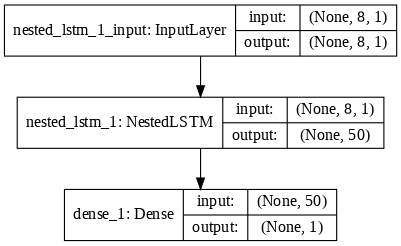

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=80)

In [ ]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(758, 8, 1) (758,) (320, 8, 1) (320,)


### Training

In [ ]:
# training
batch_size = 128

print('Training...')

checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/nestedLSTM.hdf5",
                             verbose = 1,
                             save_best_only = True,
                             monitor = "val_loss")

earlyStopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)  # early stop training when val_loss didn't improve

history = model.fit(X_train, Y_train,
                       epochs = 50,
                       batch_size = batch_size,
                       callbacks=[checkpoint, earlyStopping],
                       validation_data=(X_test, Y_test),
                       shuffle = False)

Training...

Train on 758 samples, validate on 320 samples
Epoch 1/50
758/758 [==============================] - 2s 2ms/step - loss: 0.2171 - mean_squared_error: 0.2171 - val_loss: 0.1139 - val_mean_squared_error: 0.1139

Epoch 00001: val_loss improved from inf to 0.11393, saving model to /content/gdrive/MyDrive/nestedLSTM.hdf5
Epoch 2/50
758/758 [==============================] - 0s 427us/step - loss: 0.1258 - mean_squared_error: 0.1258 - val_loss: 0.0478 - val_mean_squared_error: 0.0478

Epoch 00002: val_loss improved from 0.11393 to 0.04781, saving model to /content/gdrive/MyDrive/nestedLSTM.hdf5
Epoch 3/50
758/758 [==============================] - 0s 457us/step - loss: 0.0761 - mean_squared_error: 0.0761 - val_loss: 0.0155 - val_mean_squared_error: 0.0155

Epoch 00003: val_loss improved from 0.04781 to 0.01553, saving model to /content/gdrive/MyDrive/nestedLSTM.hdf5
Epoch 4/50
758/758 [==============================] - 0s 477us/step - loss: 0.0606 - mean_squared_error: 0.0606 - va

In [ ]:
# prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
# inverse prediction(回復預測資料值至原始數據的dimension)
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

Train Mean Absolute Error: 0.46028186199218424
Train Root Mean Squared Error: 0.5450062835028977
Test Mean Absolute Error: 0.26998004782795915
Test Root Mean Squared Error: 0.3204102723044803


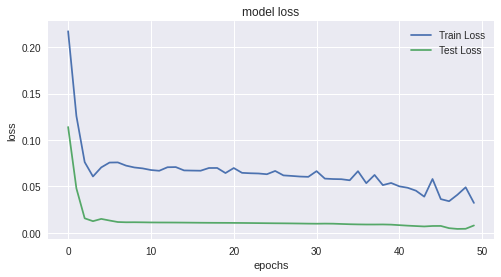

In [ ]:
# model evaluation

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
# output result
result = pd.DataFrame(
    data={
        "testing price": np.around(list(Y_test.reshape(-1)), decimals=3),
        "prediction price": np.around(list(test_predict.reshape(-1)), decimals=3)
    }
)
result

testing price  prediction price
0            2.531             2.931
1            2.498             2.927
2            2.485             2.912
3            2.502             2.903
4            2.482             2.908
..             ...               ...
315          3.727             3.529
316          3.730             3.539
317          3.734             3.543
318          3.724             3.545
319          3.720             3.541

[320 rows x 2 columns]

In [ ]:
# export result to csv
result.to_csv("comparison.csv", sep=',', index=None)

## (b) Visualize the time-rolling prediction

In [ ]:
# for plotting traning data
train_predict_plot = np.empty_like(df)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

In [ ]:
# for plotting predicted data
test_predict_plot = np.empty_like(df)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1:len(df)-1, :] = test_predict

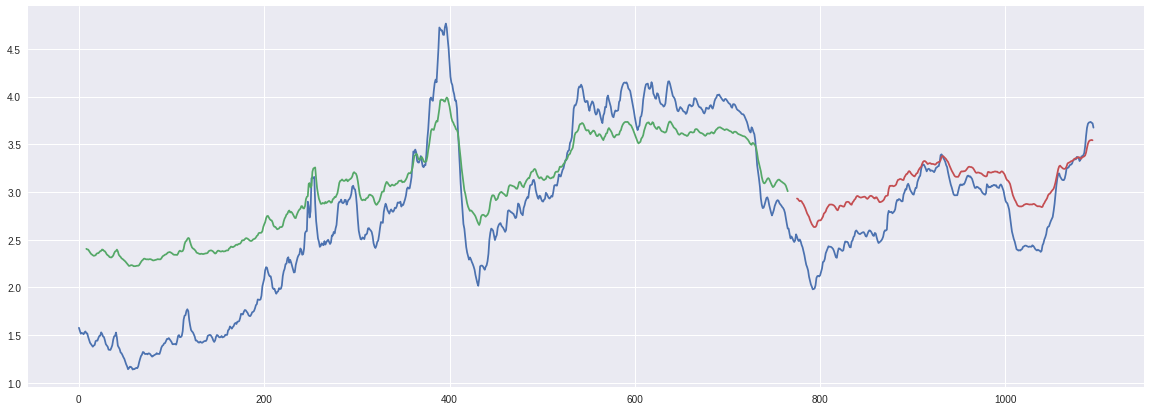

In [ ]:
# plot time-rolling prediction
plt.figure(figsize=(20, 7))
plt.plot(scaler.inverse_transform(df))  # reverse raw data
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()

## 參考來源
[1] U.S. Energy Information Administration, US Diesel Sales Price [GASDESW], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/GASDESW, December 7, 2021.

[2] [財經 M 平方：油價大事紀](https://www.macromicro.me/time_line?id=16&stat=486)

[3] [github - nlstm](https://github.com/hannw/nlstm)

[4] [arxiv: Moniz et al, "Nested LSTMs"](https://arxiv.org/abs/1801.10308)

[5] [kaggle: Predicting sales with a nested LSTM](https://www.kaggle.com/kcbighuge/predicting-sales-with-a-nested-lstm)

[6] [kaggle: Predict Future Crude Oil Prices using LSTM network](https://www.kaggle.com/mahmoud87hassan/predict-future-crude-oil-prices-using-lstm-network)

[7] [kaggle: 08-lstm-for-prediction](https://www.kaggle.com/psheon/08-lstm-for-prediction)

[8] [Day 23：銷售量預測 -- LSTM 的另一個應用](https://ithelp.ithome.com.tw/articles/10195400)